I'm going to try applying a random forest algorithm, which apparently is good for imbalanced datasets. 
https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

Import necessary libraries 

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree

#from sklearn.externals.six import StringIO  
from six import StringIO

from IPython.display import Image  
import pydotplus

print("complete")

complete


Read dataset

In [2]:
df = pd.read_csv("/Users/anthonyquint/Desktop/LHSC_Work_Folder/Mina/Bleeding_study/Ibrutinib Data Set, June 10,2021, de- identified data.csv")
df.head()

,Age at diagnosis,gender,Diagnosis year,Plt at diagnosis,plt at start of ibrutinib,plt at the time of bleed,Plt Nadir while on Ibrutinib,Platelets < 50 (Y/N),hb at diognosis,hb at start of Ibrutinib,...,action?,post op bleed? /action,INR,past medical history,PMHx bleeding risk (Y/N),Ibrutinib Dose,Comments,other ibrutinib SE,Unnamed: 43,Unnamed: 44
0,48,f,2006,260,15,NaN,15,Y,130,71,...,NaN,NaN,NaN,"deppression, schwanoma of leg",Y,"420mg,",ITP at the time of starting ibrutinib,NaN,NaN,NaN
1,66,m,2017,175,83,155,93,N,145,93,...,NaN,NaN,NaN,"cryoglobinemia,MGUS,CAD,HTN,COPD",N,420mg,NaN,NaN,NaN,NaN
2,74,F,2016,189,200,NaN,nl plts,N,116,87,...,NaN,NaN,NaN,"dm2,htn,",N,"420mg,",reaction to first obino so switched to ibrutin...,NaN,NaN,NaN
3,53,F,2002,237,67,NaN,40,Y,135,118,...,NaN,NaN,NaN,"HTN,B12 def,IDA",N,420mg,WAIHA,easy bruising,NaN,NaN
4,60,m,1999,198,85,70,49,Y,154,104,...,died,NaN,1.1,"prostitis,mycosis,chronc sinusitis",N,ibrutinib dose reduced to 140 in oct 2015 for ...,"cutaneous oral mucosal involvement w CLL, als...",NaN,NaN,NaN


Cleaning the dataset

In [3]:
#Removing all columns except the columns corresponding to our relevant 
#independent variables (indicated at top of notebook) and dependent variable (Major Bleed (Y/N))

df = df[["Age at diagnosis","gender","Platelets < 50 (Y/N)","Anemia (hb < 110) (Y/N)", "HR Molecular/Cytogenetics (Y/N)","Prior lines of therapy","anticoagulation (Y/N)","anti platelet (Y/N)","PMHx bleeding risk (Y/N)","Major Bleed (Y/N)"]]

#Gender has inputs of F or M, but sometimes they are lowercase. Using "upper()" to ensure they are all uppercase

df['gender'] = df['gender'].str.upper()

# removing rows that have "Unknown" cytogenetics.  
# df = df[~df['HR Molecular/Cytogenetics (Y/N)'].isin(['unknown'])] 

#changing NaN values in "Major Bleed (Y/N)" to M. I.e. Y = major bleed, N = minor bleed, M = no bleed 
df['Major Bleed (Y/N)'].fillna('M', inplace=True)

# Delete index 112 since it has a question mark for age 
df = df.drop(labels=112, axis=0)

df.head()

,Age at diagnosis,gender,Platelets < 50 (Y/N),Anemia (hb < 110) (Y/N),HR Molecular/Cytogenetics (Y/N),Prior lines of therapy,anticoagulation (Y/N),anti platelet (Y/N),PMHx bleeding risk (Y/N),Major Bleed (Y/N)
0,48,F,Y,Y,Y,1,N,N,Y,M
1,66,M,N,Y,Y,0,N,Y,N,N
2,74,F,N,Y,Y,1,N,N,N,M
3,53,F,Y,N,N,2,N,N,N,M
4,60,M,Y,Y,N,3,N,N,N,Y


Counting number of people who had major vs. minor vs. no bleed

In [4]:
df['Major Bleed (Y/N)'].value_counts(dropna=False)   #Counting number of people who had major vs. minor bleed

## should 0 and 1 appear roughly at equal frequencies? ##

M    127
N     25
Y     17
Name: Major Bleed (Y/N), dtype: int64

Converting categorical data into numerical representation

In [5]:
number = LabelEncoder()
df['gender'] = number.fit_transform(df['gender'].astype('str'))
df['Platelets < 50 (Y/N)'] = number.fit_transform(df['Platelets < 50 (Y/N)'].astype('str'))
df['Anemia (hb < 110) (Y/N)'] = number.fit_transform(df['Anemia (hb < 110) (Y/N)'].astype('str'))
df['HR Molecular/Cytogenetics (Y/N)'] = number.fit_transform(df['HR Molecular/Cytogenetics (Y/N)'].astype('str'))
df['anticoagulation (Y/N)'] = number.fit_transform(df['anticoagulation (Y/N)'].astype('str'))
df['anti platelet (Y/N)'] = number.fit_transform(df['anti platelet (Y/N)'].astype('str'))
df['PMHx bleeding risk (Y/N)'] = number.fit_transform(df['PMHx bleeding risk (Y/N)'].astype('str'))
df['Major Bleed (Y/N)'] = number.fit_transform(df['Major Bleed (Y/N)'].astype('str'))


df.head()

,Age at diagnosis,gender,Platelets < 50 (Y/N),Anemia (hb < 110) (Y/N),HR Molecular/Cytogenetics (Y/N),Prior lines of therapy,anticoagulation (Y/N),anti platelet (Y/N),PMHx bleeding risk (Y/N),Major Bleed (Y/N)
0,48,0,1,1,1,1,0,0,1,0
1,66,1,0,1,1,0,0,1,0,1
2,74,0,0,1,1,1,0,0,0,0
3,53,0,1,0,0,2,0,0,0,0
4,60,1,1,1,0,3,0,0,0,2


Splitting data into independent and dependent variables, then into training and testing sets. 

In [6]:
clinical_features = ['Age at diagnosis','gender','Platelets < 50 (Y/N)','Anemia (hb < 110) (Y/N)','HR Molecular/Cytogenetics (Y/N)','Prior lines of therapy','anticoagulation (Y/N)','anti platelet (Y/N)','PMHx bleeding risk (Y/N)']
#clinical_features = ['Age at diagnosis','gender','Platelets < 50 (Y/N)','Anemia (hb < 110) (Y/N)','Prior lines of therapy','anticoagulation (Y/N)','anti platelet (Y/N)','PMHx bleeding risk (Y/N)']

X = df[clinical_features]   #Independent variables 
y = df['Major Bleed (Y/N)']  #Dependent variables 

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0, stratify=y) #Splitting variables into training/testing set

#########

X_Y_train = pd.concat([X_train,y_train],axis=1)

def upsample_minority(df):
    
    df_majority = df.loc[df['Major Bleed (Y/N)'] == 0]
    df_minority_1 = df.loc[df['Major Bleed (Y/N)'] == 1]
    df_minority_2 = df.loc[df['Major Bleed (Y/N)'] == 2]
    
    df_minority_1_upsampled = resample(df_minority_1, replace = True, n_samples=len(df_majority), random_state=123)
    df_minority_2_upsampled = resample(df_minority_2, replace = True, n_samples=len(df_majority), random_state=123)
    
    df_upsampled = pd.concat([df_majority,df_minority_1_upsampled,df_minority_2_upsampled])
    
    df = df_upsampled
    
    return df 

def smote(train_1,train_2):
    
    sm = SMOTE(random_state=27)
    train_1, train_2 = sm.fit_resample(train_1, train_2)
    
    return train_1,train_2 

#upsampling the minority directly
X_Y_train_upsample = upsample_minority(X_Y_train)
y_train_upsample = X_Y_train_upsample['Major Bleed (Y/N)']
X_train_upsample = X_Y_train_upsample.drop('Major Bleed (Y/N)', axis=1)

df_upsample = upsample_minority(df)
y_upsample = df_upsample['Major Bleed (Y/N)']
X_upsample = df_upsample.drop('Major Bleed (Y/N)', axis=1)

#upsampling by generating synthetic samples (smote)
X_train_smote, y_train_smote = smote(X_train, y_train)

X_smote, y_smote = smote(X, y)

# Choosing which of the 2 sets of upsampled data I'll make the model with (upsampling vs. smote). 
# Seems like the original training and upsample > smote. Not sure which would be best. 
XX = X_train
yy = y_train

#X_Y_train_upsample['Major Bleed (Y/N)'].value_counts(dropna=False)


## https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

Model Implementation/Performance metrics

In [7]:
rfc = RandomForestClassifier(n_estimators=10, max_depth=3).fit(XX, yy)

rfc_pred = rfc.predict(X_test)

accuracy_score(y_test, rfc_pred)
#f1_score(y_test, rfc_pred)
#recall_score(y_test, rfc_pred)

0.813953488372093

In [8]:
confusion_matrix(y_test, rfc_pred)

array([[32,  0,  0],
       [ 6,  1,  0],
       [ 2,  0,  2]])

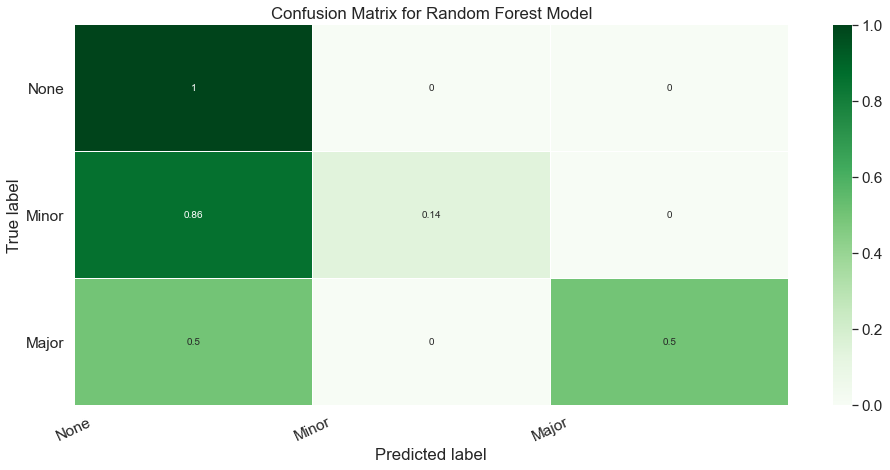

In [9]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, rfc_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['None','Minor','Major']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [10]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        32
           1       1.00      0.14      0.25         7
           2       1.00      0.50      0.67         4

    accuracy                           0.81        43
   macro avg       0.93      0.55      0.60        43
weighted avg       0.85      0.81      0.76        43



In [11]:
rfc.feature_importances_

array([0.25157891, 0.01014857, 0.02354235, 0.04724804, 0.13633193,
       0.08391177, 0.2494276 , 0.12362618, 0.07418467])

In [12]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Age at diagnosis,0.251579
anticoagulation (Y/N),0.249428
HR Molecular/Cytogenetics (Y/N),0.136332
anti platelet (Y/N),0.123626
Prior lines of therapy,0.083912
PMHx bleeding risk (Y/N),0.074185
Anemia (hb < 110) (Y/N),0.047248
Platelets < 50 (Y/N),0.023542
gender,0.010149


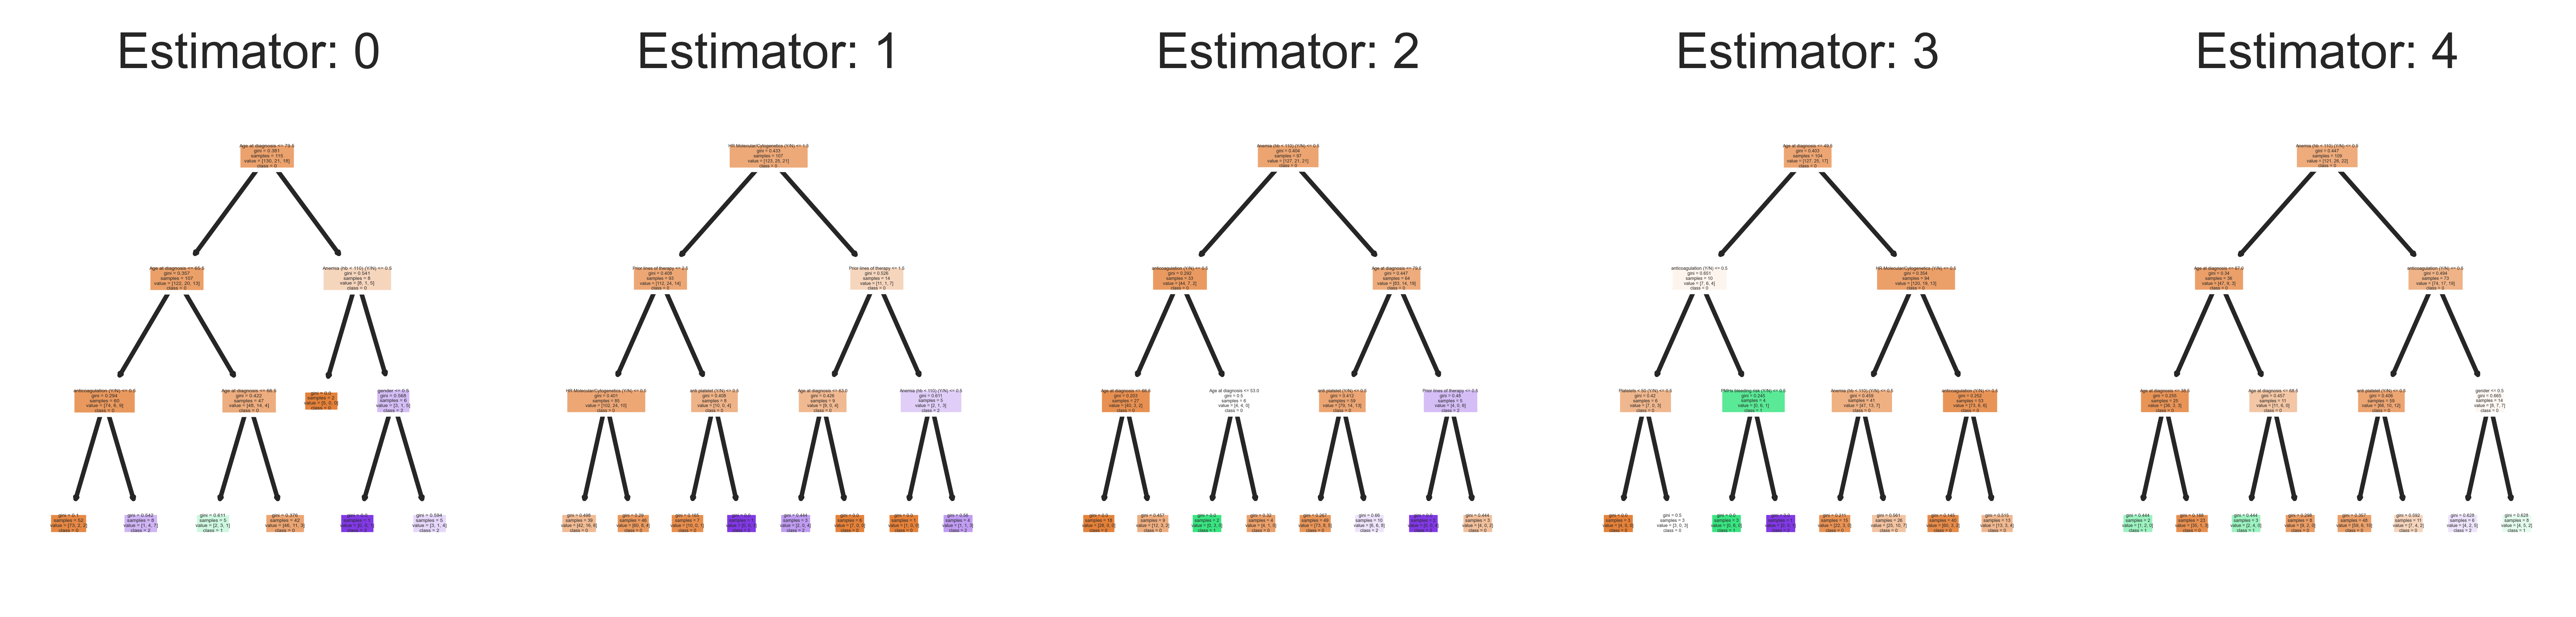

In [13]:
#rfc.estimators_[0]

#dot_data = StringIO()
#i_tree = 0

#for tree_in_forest in rfc.estimators_: 
#    if (i_tree<1): 
        
#        export_graphviz(tree_in_forest,out_file=dot_data,feature_names=clinical_features,class_names=['0','1','2'],filled=True,rounded=True)
#        graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#        graph.write_png("bleeding" + str(i_tree) + ".png")
#       Image(graph.create_png())
#        i_tree = i_tree + 1
        

    # This may not the best way to view each estimator as it is small
fn = clinical_features
cn = ['0','1','2']
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(rfc.estimators_[index],
                   feature_names = fn, 
                   class_names=cn,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
# fig.savefig('rf_MajMinNone_NoSplit.png')  # saving figure 

#https://stackoverflow.com/questions/40155128/plot-trees-for-a-random-forest-in-python-with-scikit-learn

        

   
